In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [4]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [100,200,300,400,500,600,700,800,900,1000]
margins_to_sample = [200, 500]
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Generate Test Dataset

In [114]:
# Extract test features

test_addresses = defaultdict(list)

labels_found = set([])

for stack in all_annotated_ntb_stacks:

    annotation_grid_indices_fn = os.path.join(ANNOTATION_ROOTDIR, stack, stack + '_annotation_grid_indices.h5')
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels_found = labels_found | labels_this_stack
    
    test_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, 
                                                  num_samples_per_landmark=100)
    
    for label, addresses in test_addresses_sec_idx.iteritems():
        test_addresses[label] += [(stack, ) + addr for addr in addresses]
        
test_addresses.default_factory = None

In [115]:
test_features = apply_function_to_dict(addresses_to_features, test_addresses)

('MD635', 75)
('MD635', 76)
('MD635', 77)
('MD635', 78)
('MD635', 79)
('MD635', 80)
('MD635', 81)
('MD635', 82)
('MD635', 83)
('MD635', 84)
('MD635', 85)
('MD635', 86)
('MD635', 87)
('MD635', 88)
('MD635', 89)


Patch in annotation but not in mask: MD635 89 MD635-F30-2016.05.18-22.15.39_MD635_2_0089 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @215


('MD635', 90)
('MD635', 91)


Patch in annotation but not in mask: MD635 91 MD635-F31-2016.05.18-22.31.18_MD635_1_0091 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @181


('MD635', 92)


Patch in annotation but not in mask: MD635 92 MD635-F31-2016.05.18-22.31.18_MD635_2_0092 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @159


('MD635', 94)
('MD635', 95)
('MD635', 96)
('MD635', 97)
('MD635', 98)
('MD635', 99)
('MD635', 100)
('MD635', 101)
('MD635', 102)
('MD635', 103)
('MD635', 104)


Patch in annotation but not in mask: MD635 104 MD635-F35-2016.05.18-23.40.52_MD635_2_0104 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @96


('MD635', 105)
('MD635', 106)
('MD635', 107)
('MD635', 108)
('MD635', 109)
('MD635', 110)
('MD635', 111)
('MD635', 112)
('MD635', 113)
('MD635', 114)
('MD635', 115)
('MD635', 116)
('MD635', 117)
('MD635', 118)
('MD635', 119)
('MD635', 120)
('MD635', 121)
('MD635', 122)
('MD635', 123)
('MD635', 124)
('MD635', 125)
('MD635', 126)
('MD635', 127)
('MD635', 128)
('MD635', 129)
('MD635', 130)
('MD635', 131)
('MD635', 132)
('MD635', 133)
('MD635', 134)
('MD635', 135)
('MD635', 136)
('MD635', 137)
('MD635', 138)
('MD635', 139)
('MD635', 140)
('MD635', 141)


Patch in annotation but not in mask: MD635 141 MD635-F47-2016.05.19-03.19.48_MD635_3_0141 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @101


('MD635', 142)
('MD635', 143)
('MD635', 144)
('MD635', 145)
('MD635', 146)
('MD635', 147)
('MD635', 148)
('MD635', 149)
('MD635', 150)
('MD635', 151)
('MD635', 152)
('MD635', 153)
('MD635', 154)
('MD635', 155)
('MD635', 156)
('MD635', 157)
('MD635', 158)
('MD635', 159)
('MD635', 160)
('MD635', 161)
('MD635', 162)
('MD635', 163)
('MD635', 164)
('MD635', 165)
('MD635', 166)
('MD635', 167)
('MD635', 168)
('MD635', 169)


Patch in annotation but not in mask: MD635 169 MD635-F58-2016.05.19-06.52.57_MD635_2_0173 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @160


('MD635', 170)
('MD635', 171)
('MD635', 172)
('MD635', 173)
('MD635', 174)
('MD635', 175)
('MD635', 176)
('MD635', 177)
('MD635', 178)
('MD635', 179)
('MD635', 180)
('MD635', 181)
('MD635', 182)
('MD635', 183)
('MD635', 184)
('MD635', 185)
('MD635', 186)
('MD635', 187)
('MD635', 188)
('MD635', 189)
('MD635', 190)
('MD635', 191)
('MD635', 192)
('MD635', 193)
('MD635', 194)
('MD635', 195)
('MD635', 196)
('MD635', 197)
('MD635', 198)
('MD635', 199)
('MD635', 200)


Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21039
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20780


('MD635', 201)
('MD635', 202)
('MD635', 203)
('MD635', 204)
('MD635', 206)
('MD635', 207)


Patch in annotation but not in mask: MD635 207 MD635-F77-2016.05.19-13.07.42_MD635_2_0230 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @118


('MD635', 208)
('MD635', 209)
('MD635', 210)
('MD635', 211)
('MD635', 212)
('MD635', 213)
('MD635', 214)
('MD635', 216)
('MD635', 217)
('MD635', 218)
('MD635', 219)
('MD635', 220)
('MD635', 221)
('MD635', 222)
('MD635', 223)
('MD635', 224)
('MD635', 225)
('MD635', 226)
('MD635', 227)
('MD635', 228)
('MD635', 229)
('MD635', 230)
('MD635', 231)
('MD635', 233)
('MD635', 234)
('MD635', 235)


Patch in annotation but not in mask: MD635 235 MD635-F91-2016.05.19-17.33.31_MD635_2_0272 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @31


('MD635', 236)
('MD635', 237)
('MD635', 238)
('MD635', 239)
('MD635', 240)


In [116]:
test_features = {label: np.array([f for f in feats if f is not None]) 
                 for label, feats in test_features.iteritems()}

In [117]:
for label, feats in test_features.iteritems():
    print label, len(feats)

12N_surround_500_AP 100
RtTg_surround_200_Tz 3
VCA_surround_200_DC 5
AP_negative 100
Tz_negative 100
SNC_surround_500_SNR 100
VCA_surround_200_VCP 100
SNR_surround_500_SNC 100
SC_surround_500_IC 100
5N 100
SNC_surround_500_noclass 100
6N_surround_500_7n 100
DC_surround_200_VCA 5
7n_surround_200_noclass 100
12N 100
DC_surround_200_VCP 29
6N_negative 100
LC_negative 100
VCA_surround_500_VCP 100
SNC_surround_200_SNR 100
VCA_surround_500_noclass 100
VCP_surround_200_VCA 100
Sp5C 100
SC_surround_200_noclass 100
SNC 100
LC_surround_500_noclass 100
Tz_surround_200_RtTg 8
DC_surround_500_VCA 100
Pn_surround_200_RtTg 100
10N_surround_200_noclass 100
7n_negative 100
DC_surround_500_VCP 100
noclass 100
7n_surround_200_6N 54
Pn_surround_200_noclass 100
RtTg 100
Pn 98
SNR_surround_200_noclass 100
10N 100
VLL 100
RtTg_surround_500_Tz 100
VCP_negative 98
SNC_negative 99
IC_surround_500_noclass 100
IC_surround_200_noclass 100
12N_surround_500_noclass 100
SNR 100
7N_surround_500_7n 100
Pn_surround_500_

In [118]:
# Save this set as dataset 2.

dataset = 4

test_feat_dir = create_if_not_exists(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features'))

# Save test features
for label, feats in test_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, label + '.bp'))
    
# Save test addresses
save_pickle(test_addresses, os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))

In [53]:
structures_found = sorted(set([convert_to_original_name(l) for l in labels_found]) - {'noclass'})

# Load Test Features

In [134]:
dataset = 4

In [135]:
# load test addresses
test_addresses = load_pickle(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))
test_addresses = {l: addrs for l, addrs in test_addresses.iteritems() if l in labels_to_sample}

In [136]:
# Load test features

test_features = {}
for label in labels_to_sample:
    feat_fp = os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features', label + '.bp')
    if os.path.exists(feat_fp):
        test_features[label] = bp.unpack_ndarray_file(feat_fp)

In [137]:
assert set(test_addresses.keys()) == set(test_features.keys()), \
'Test features and test addresses are not consistent.'

In [138]:
labels_found = test_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

# Load pre-computed svm classifiers

In [159]:
setting = 2
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % setting))

In [160]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for sp5 is found.
No classifier for outerContour is found.


# Generate Evaluation Results

In [161]:
eval_dir = create_if_not_exists(os.path.join(setting_dir, 'eval'))

In [106]:
# Compute x vs. all negative accuracy

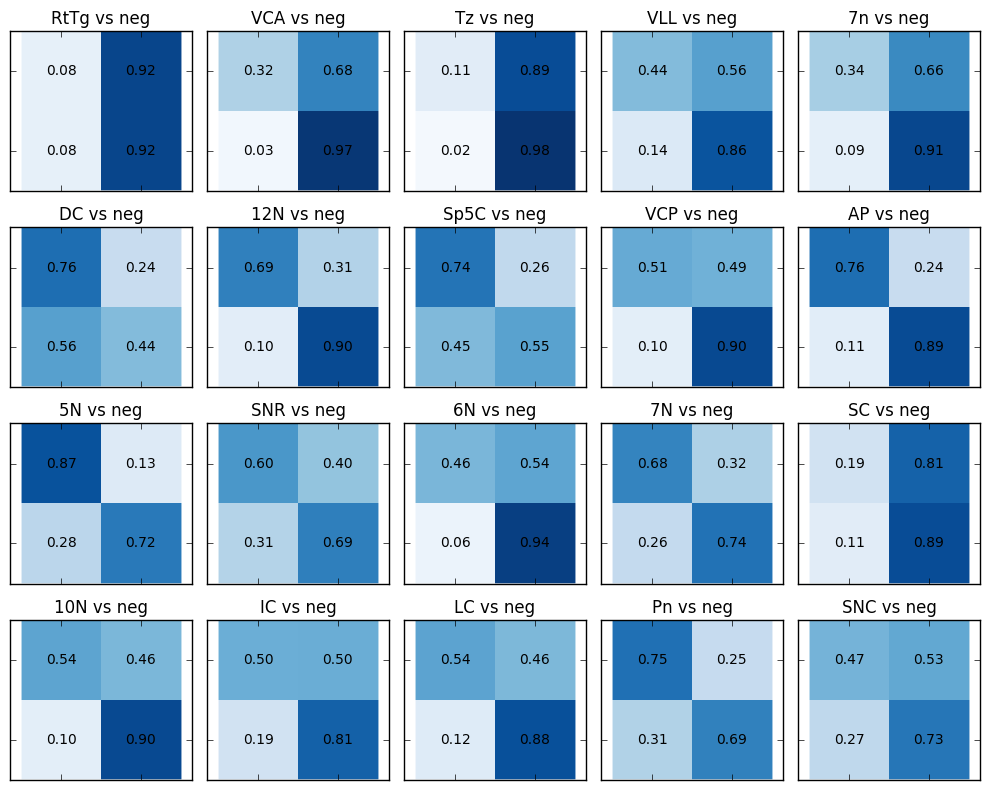

In [107]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features[structure + '_negative']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs neg'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()

In [108]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.667455853882


In [109]:
single_vs_negative_cm_plot_fp = os.path.join(eval_dir, 'single_vs_negative_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(single_vs_negative_cm_plot_fp, bbox_inches='tight')

# Compute x vs. noclass accuracy

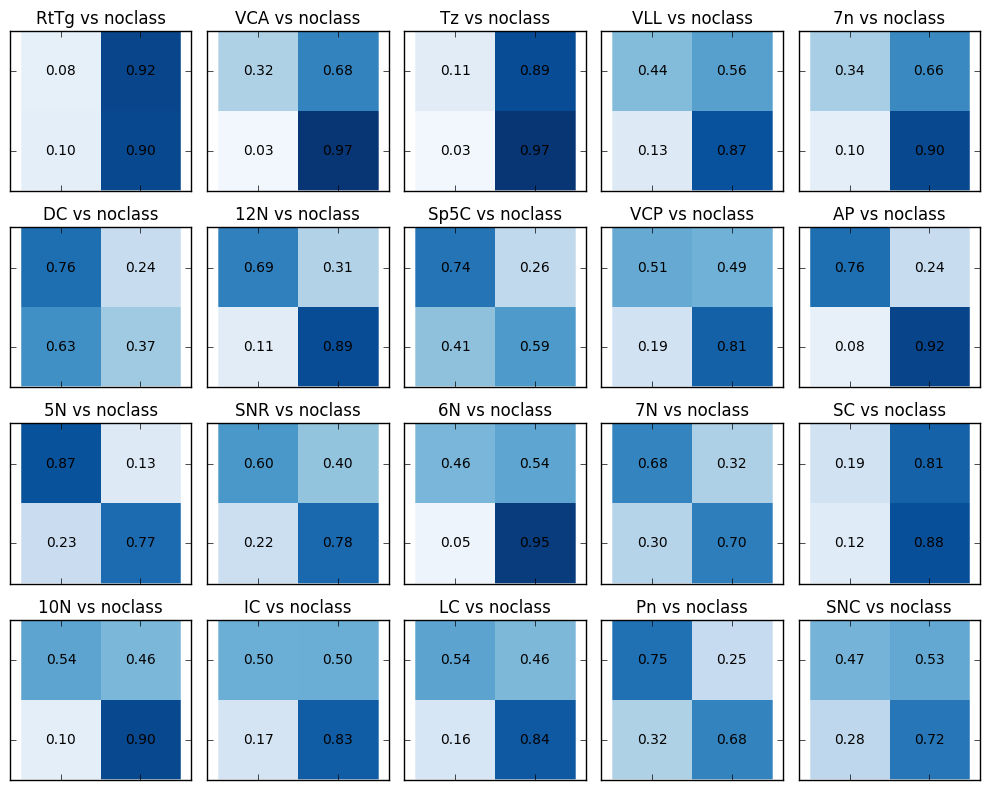

In [110]:
# Compute x vs. noclass accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features['noclass']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs noclass'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()

In [111]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.6666512726


In [112]:
single_vs_noclass_cm_plot_fp = os.path.join(eval_dir, 'single_vs_noclass_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(single_vs_noclass_cm_plot_fp, bbox_inches='tight')

# Compute surround accuracy (margin = 200)

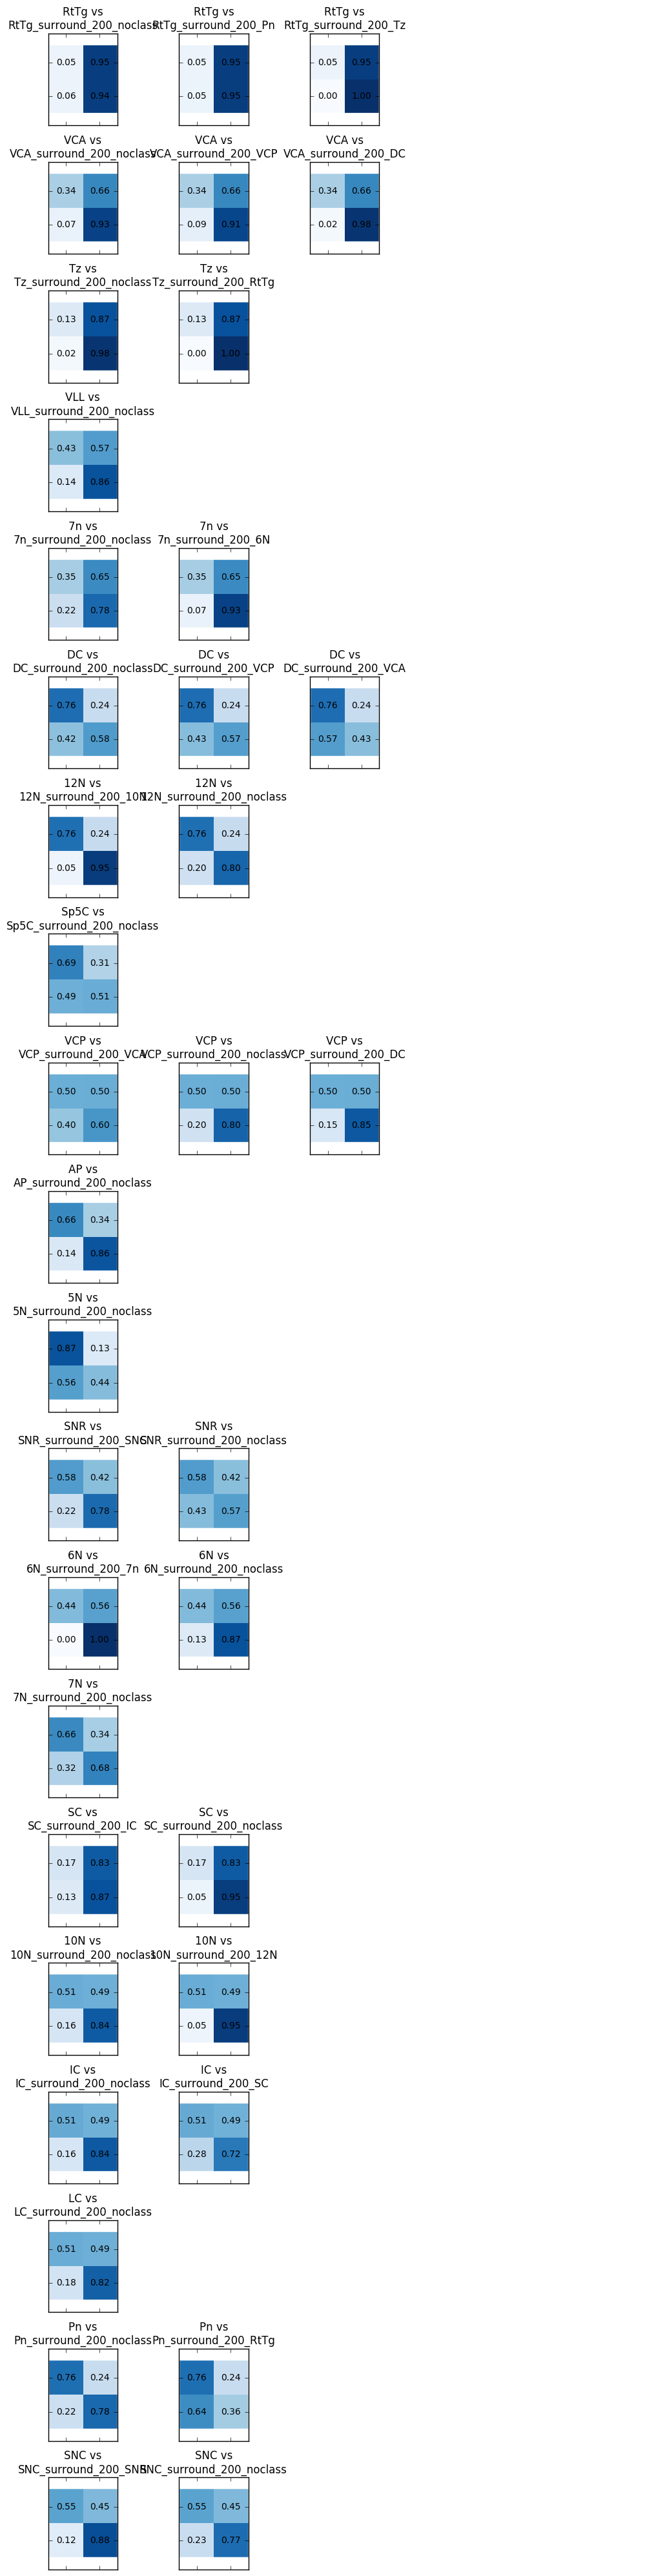

In [162]:
# Compute surround accuracy (margin = 200)

margin = 200
acc_all_pairs = {}

ncols = 5
nrows = len(structures_found)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
# axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    for j, neg_class in enumerate(neg_classes):

        features_neg = test_features[neg_class]
        n_neg = len(features_neg)

        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=True)

        plot_confusion_matrix(cm, title='%(structure)s vs\n%(neg_class)s'% {'structure':structure, 'neg_class': neg_class},
                              labels=['',''], xlabel='', ylabel='',
                             axis=axes[i, j])

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=False)
        acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
        acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc
        
    for j in range(len(neg_classes), ncols):
        axes[i,j].axis('off')

plt.tight_layout()

In [163]:
surround_cm_plot_fp = os.path.join(eval_dir, 'surround_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(surround_cm_plot_fp, bbox_inches='tight')

In [164]:
print np.mean(acc_all_pairs.values())

0.607996176207


In [72]:
sorted(acc_all_pairs.items(), key=lambda (x,y): y)

[('SC vs SC_surround_200_IC', 0.54535345166832483),
 ('IC vs IC_surround_200_SC', 0.63378344327912872),
 ('10N vs 10N_surround_200_noclass', 0.66050820739068417),
 ('SNC vs SNC_surround_200_noclass', 0.6633200091275756),
 ('RtTg vs RtTg_surround_200_noclass', 0.6714797206147668),
 ('6N vs 6N_surround_200_noclass', 0.68985533506809538),
 ('VCP vs VCP_surround_200_noclass', 0.69551525152803007),
 ('SNR vs SNR_surround_200_noclass', 0.69812509104994369),
 ('LC vs LC_surround_200_noclass', 0.69853481782094007),
 ('Tz vs Tz_surround_200_noclass', 0.70507607073460576),
 ('SC vs SC_surround_200_noclass', 0.71317376942676081),
 ('7N vs 7N_surround_200_noclass', 0.71696350213779547),
 ('12N vs 12N_surround_200_noclass', 0.72143003058763044),
 ('VCP vs VCP_surround_200_VCA', 0.73092031183557071),
 ('Pn vs Pn_surround_200_RtTg', 0.73416013205951769),
 ('Sp5C vs Sp5C_surround_200_noclass', 0.73950306731435578),
 ('RtTg vs RtTg_surround_200_Pn', 0.74218217411311727),
 ('VLL vs VLL_surround_200_nocl

# Compute surround accuracy for different margins

In [73]:
# Compute surround accuracy for different margins

acc_all_margins = {}

for margin in margins_to_sample:

    print 'margin = %d' % margin

    acc_all_pairs = {}

    for i, structure in enumerate(structures_found):

        features_pos = test_features[structure]
        n_pos = len(features_pos)

        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
        [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]
        
        neg_classes = list(set(neg_classes) & set(labels_found))

        for j, neg_class in enumerate(neg_classes):
    #         print 'comparing with', neg_class

            features_neg = test_features[neg_class]

            n_neg = len(features_neg)

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

            acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
            acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc

    acc_all_margins[margin] = acc_all_pairs

margin = 200
margin = 500


In [74]:
# overall_acc_all_margins = {margin: vals['10N vs 10N_surround_%d_12N' % margin] for margin, vals in acc_all_margins.iteritems()}
overall_acc_all_margins = {margin: np.mean(vals.values()) for margin, vals in acc_all_margins.iteritems()}

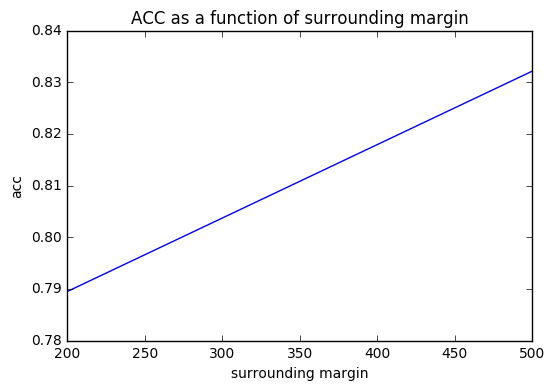

In [75]:
plt.plot(sorted(overall_acc_all_margins.keys()), 
         [overall_acc_all_margins[i] for i in sorted(overall_acc_all_margins.keys())]);
plt.xlabel('surrounding margin');
plt.ylabel('acc');
plt.title('ACC as a function of surrounding margin');

# Compute pairwise accuracy

In [76]:
# Compute pairwise accuracy

n_structures = len(structures_found)
pairwise_cm = np.zeros((n_structures, n_structures))

# for i, label in enumerate(structures):
# axes_id = 0
for i, structure in enumerate(structures_found):
    
#     print i, structure
    
    features_pos = test_features[structure]
    n_pos = len(features_pos)
        
    for j, structure2 in enumerate(structures_found):
        if i > j:
            continue
            
        if i == j:
            pairwise_cm[i,j] = 1
            continue
        
#         print 'comparing with', j, structure2
        
        features_neg = test_features[structure2]
        n_neg = len(features_neg)
        
        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm_sub = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)
        
#         acc = .5 * (cm_sub[0,0] + cm_sub[1,1])
        acc = (cm_sub[0,0] + cm_sub[1,1]) / (n_pos + n_neg)
        pairwise_cm[i,j] = acc
#         cm[j,i] = acc
        
#         r = np.array([i,j])
#         cm[r, r[:,None]] = acc
        
#         plot_confusion_matrix(cm_sub, title='%(label)s vs. %(label2)s'% {'label':label, 'label2':label2},
#                           labels=['',''],
# #                           labels=[label, convert_to_surround_name(label)],
#                          axis=axes[axes_id])
        
#         axes_id += 1

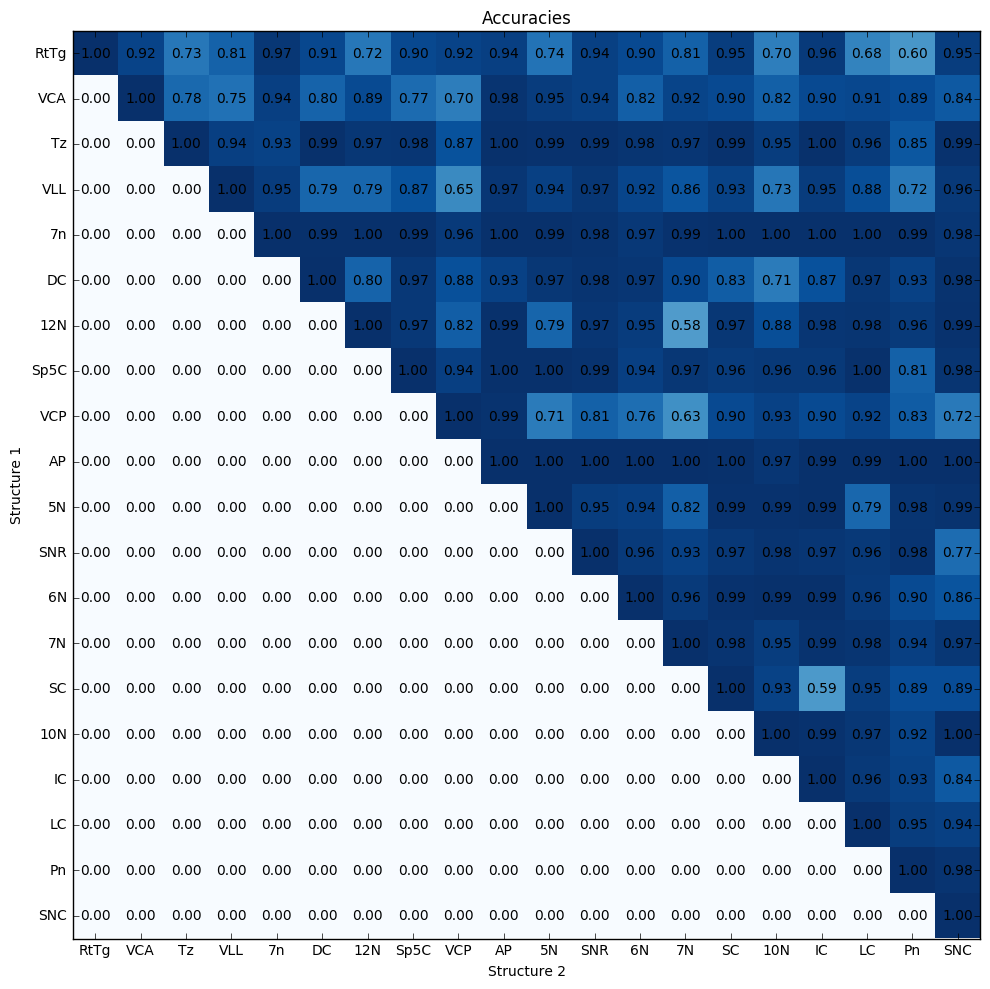

In [77]:
fig = plot_confusion_matrix(pairwise_cm, title='Accuracies',
                      labels=structures_found,
                     figsize=(10,10),
                           xlabel='Structure 2',
                           ylabel='Structure 1')

plt.tight_layout()

In [78]:
pariwise_cm_plot_fp = os.path.join(eval_dir, 'pairwise_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(pariwise_cm_plot_fp, bbox_inches='tight')